Reinforce implemented for Cartpole:

> Original PyTorch code: https://github.com/udacity/deep-reinforcement-learning/blob/master/reinforce/REINFORCE.ipynb


> Jax code from: https://github.com/matwilso/rl-implementations/blob/master/jax/reinforce.py





In [0]:
import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from jax import jacobian, lax
import jax
import jax.numpy as jp
from jax.ops import index, index_add, index_update
from jax import jit, grad, vmap, random, jacrev, jacobian, jacfwd, value_and_grad
from functools import partial
from jax.experimental import stax # neural network library
from jax.experimental.stax import GeneralConv, Conv, ConvTranspose, Dense, MaxPool, Relu, Flatten, LogSoftmax, LeakyRelu, Dropout, Tanh, Sigmoid, BatchNorm, Softmax # neural network layers
from jax.nn import softmax, sigmoid
from jax.nn.initializers import zeros
from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays

In [0]:
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return jp.array(x[:, None] == jp.arange(k), dtype)

def cumulative_returns(rewards, gamma):
    returns = jp.zeros(len(rewards))
    next_return = 0 # 0 because we start at the last timestep
    for t in reversed(range(0, len(rewards))):
        next_return = rewards[t] + gamma * next_return
        returns = index_update(returns, index[t], next_return)
    # normalize for better statistical properties
    returns = (returns - returns.mean()) / (returns.std() + jp.finfo(jp.float32).eps)
    return returns

class Policy:
    def __init__(self, rng, num_actions, s_size=4, h_size=16, a_size=2, lr=1e-2):
        super(Policy, self).__init__()
        self.key = rng
        self.init_fun, self.apply_fun = stax.serial(
            Dense(h_size), Dense(a_size), Softmax
        )
        self.in_shape = (-1, s_size)
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(step_size=lr)
        _, self.net_params = self.init_fun(self.key, self.in_shape)
        # print(net_params)
        self.opt_state = self.opt_init(self.net_params)
        self.opt_t = 1
        self.num_actions = num_actions

        def loss_fn(params, sar):
            one_hot_actions = one_hot(sar['a'], self.num_actions)
            probs = self.apply_fun(params, sar['s'])
            return jp.einsum('ij,i->',- one_hot_actions * jp.log(probs),sar['r'])

        @jit
        def step_fn(i, opt_state, sar):
            params = self.get_params(opt_state)
            l, g = value_and_grad(loss_fn)(params, sar)
            return self.opt_update(i, g, opt_state), l
        self.step = step_fn


    def update_key(self):
        self.key, _ = jax.random.split(self.key)
        return self.key

    def act(self, state):
        probs = self.apply_fun(self.net_params, state)
        uf = jax.random.uniform(self.update_key(), (1,), minval=0.0, maxval=1.0)[0]
        action = jp.argmax(uf < jp.cumsum(probs))
        # print(action, probs, uf)
        return action.item()#, jp.log(probs[action])

    def update(self, sar, gamma=1.0):
        sar['r'] = cumulative_returns(sar['r'], gamma)
        sar['s'] = jp.array(sar['s'])
        sar['a'] = jp.array(sar['a'])

        self.opt_state, loss = self.step(self.opt_t, self.opt_state, sar)
        self.opt_t += 1
        self.net_params = self.get_params(self.opt_state)
        return loss



In [0]:
def reinforce(env, policy, n_episodes=10000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        # print(f"Episode {i_episode}")
        saved_log_probs = []
        rewards = []
        sar = {key: [] for key in 'sar'}
        state = env.reset()
        # print(f'State:{state}')
        for t in range(max_t):
            action = policy.act(state)
            sar['s'].append(state)
            sar['a'].append(action)
            state, reward, done, _ = env.step(action)
            sar['r'].append(reward)
            rewards.append(reward)
            if done:
                # print(f'Done {t}')
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        l = policy.update(sar, gamma)
        # print(f'loss {l}')
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores

def plot_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()


observation space: Box(4,)
action space: 2
Episode 100	Average Score: 32.36
Episode 200	Average Score: 41.18
Episode 300	Average Score: 47.87
Episode 400	Average Score: 56.42
Episode 500	Average Score: 75.82
Episode 600	Average Score: 114.67
Episode 700	Average Score: 128.57
Episode 800	Average Score: 158.77
Episode 900	Average Score: 176.69
Episode 1000	Average Score: 184.49
Episode 1100	Average Score: 183.12
Episode 1200	Average Score: 178.01
Environment solved in 1183 episodes!	Average Score: 195.41


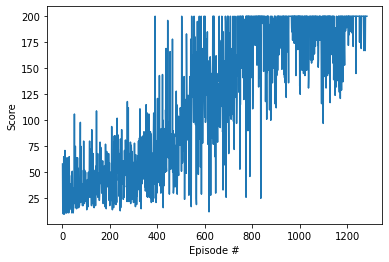

In [16]:
def main():
    env = gym.make('CartPole-v0')
    env.seed(0)
    print('observation space:', env.observation_space)
    print('action space:', env.action_space.n)
    rng = jax.random.PRNGKey(0)
    pi = Policy(rng, env.action_space.n, lr=1e-3)
    scores = reinforce(env, pi)
    plot_scores(scores)

if __name__ == '__main__':
    main()